# Improving Oura Ring REM Sleep Score
<img src="https://ouraring.com/static/images/default_seo_image.png" width="250" height="250" align="left">

# Table of Contents
***
### The Problem

- [Why does REM sleep matter](#problem)

### Data Quality Check
- [Simple Inspection of Data](#datacleaning)

### Descriptive Statistics
- [Summary Statistics, REM Distribution, Size of Data](#descriptive_statistics)
- [Correlation Matrix](#correlation_matrix)

### Exploratory Data Analysis
- [Investigate REM Scores](#explore_target)
- [Sleep Trends Over Time](#sleep_trends)
- [Wake Up Time VS Total Sleep Time](#wakeup_vs_total_sleep)
- [Feature Importance](#feat_importance)


### Conclusion
- [Tips to Improve REM](#rem_plan)

***

### Objective: 
- To understand what factors contributed most to REM sleep.

- To perform clustering to find any meaningful patterns of REM sleep.

- To see how lifestyle change actually impacts score.

<a id='problem'></a>
### The Problem:

My Oura Ring shows that **I need more REM sleep**.

REM sleep is a critical stage of sleep where experiences are consolodated into memory. It's considered the source of creativity and idea breakthroughs.

Instead of going by *feel*, my Oura quantifies quantity of REM. I can tweak my lifestyle and see the impact on REM.

### Background

Rapid eye movement (REM) sleep is a critical stage of sleep where experiences are consolodated into memory and is considered the source of creativity and idea breakthroughs. Dubbed the "informational alchemy" stage, during REM the brain combines memories in novel ways.

### Data Collection
Data came from my wearable device called the Oura Ring. It collects vast amounts of sleep data. But it isn't very useful on its own.

### Hypothesis
Days full of activity, longer sleep times, waking up later, and higher HRV scores will lead to greater REM sleep.
***

## Import Libraries
***

In [265]:
# Import the neccessary modules for data manipulation and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)

__author__ = 'Nick Urban'
__website__ = 'nicholasjurban.com'

## Read the Data
***

In [246]:
#load the JSON data into a Pandas dataframe
path = '/Users/Nick/Desktop/Backup/Data Science/oura_2020-07-30T19-06-01.json'
with open(path) as f:
    data = json.load(f)

df = pd.DataFrame(data['sleep'])

- Oura JSON contains four keys: `activity`, `readiness`, `restful_periods`, `sleep`


In [247]:
# Load other Oura data for additional features
df_active = pd.DataFrame(data['activity'])
df_ready = pd.DataFrame(data['readiness'])

In [248]:
# Load my personal self-quantification dataset 
df_habits = pd.read_csv('Datasets/notion-daily-log-2020-09-17.csv', parse_dates=['Date'], index_col='Date')

In [249]:
# Preview the column names
print(df_active.columns, '\n')
print(df.columns)

Index(['average_met', 'cal_active', 'cal_total', 'class_5min',
       'daily_movement', 'day_end', 'day_start', 'high', 'inactive',
       'inactivity_alerts', 'low', 'medium', 'met_1min', 'met_min_high',
       'met_min_inactive', 'met_min_low', 'met_min_medium', 'non_wear', 'rest',
       'score', 'score_meet_daily_targets', 'score_move_every_hour',
       'score_recovery_time', 'score_stay_active', 'score_training_frequency',
       'score_training_volume', 'steps', 'summary_date', 'target_calories',
       'target_km', 'target_miles', 'timezone', 'to_target_km',
       'to_target_miles', 'total'],
      dtype='object') 

Index(['awake', 'bedtime_end', 'bedtime_end_delta', 'bedtime_start',
       'bedtime_start_delta', 'breath_average', 'deep', 'duration',
       'efficiency', 'hr_5min', 'hr_average', 'hr_lowest', 'hypnogram_5min',
       'is_longest', 'light', 'midpoint_at_delta', 'midpoint_time',
       'onset_latency', 'period_id', 'rem', 'restless', 'rmssd', 'rmssd_5min',
      

In [250]:
df_active.head(2)

,average_met,cal_active,cal_total,class_5min,daily_movement,day_end,day_start,high,inactive,inactivity_alerts,low,medium,met_1min,met_min_high,met_min_inactive,met_min_low,met_min_medium,non_wear,rest,score,score_meet_daily_targets,score_move_every_hour,score_recovery_time,score_stay_active,score_training_frequency,score_training_volume,steps,summary_date,target_calories,target_km,target_miles,timezone,to_target_km,to_target_miles,total
0,1.15625,204,2557,0000000000000000000000000000000000000000000000...,3436,2018-09-25T03:59:59-07:00,2018-09-24T04:00:00-07:00,0,263,1,75,22,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0,2,68,71,746,334,94,78,95,100,100,100,98,4559,2018-09-24,550,9,6.0,-420,5.7,3.5,97
1,1.56250,657,3194,1111111111111211111111121122333333222222233322...,10176,2018-09-26T03:59:59-07:00,2018-09-25T04:00:00-07:00,1,710,1,234,75,"[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...",8,12,161,274,25,395,91,95,95,100,56,100,99,13456,2018-09-25,550,10,6.0,-420,-1.6,-1.0,310


In [251]:
# Convert the date field to Pandas DT object
df['summary_date'] = pd.to_datetime(df['summary_date'])
df_ready['summary_date'] = pd.to_datetime(df_ready['summary_date'])

In [252]:
def split_tags_binarizer(string, match_tag=''):
    """ Takes a list of tags separate by a comma and space and returns 1 if it's found otherwise 0. """
    results = []
    try:
        for item in string.split(', '):
            if item == match_tag:
                return 1
    except:
        pass
    return 0

df_habits['mouth_taping'] = df_habits['Tags'].apply(lambda x: split_tags_binarizer(x, 'Mouth Taping (Sleep)'))

In [253]:
df_habits['mouth_taping'].value_counts()

0    711
1     81
Name: mouth_taping, dtype: int64

- I started mouth taping recently, so I expect the disproportionate number of 0s.

In [254]:
# Get features from other datasets

# Readiness dataset
df['score_resting_hr'] = df_ready['score_resting_hr']
df['score_recovery_index'] = df_ready['score_recovery_index']

# Activity dataset
df['inactive_mins'] = df_active['inactive']
df['steps'] = df_active['steps']
df['cal_active'] = df_active['cal_active']
df['met_rate'] = df_active['average_met']

df = df.merge(right=df_habits[['Alcoholic Drinks', 'mouth_taping']], how='left', left_on=['summary_date'], right_on='Date')

# Rename new column to match column name format
df.rename(columns={'Alcoholic Drinks':'drinks_alcohol'}, inplace=True)

# Fill the nulls
df['drinks_alcohol'].fillna(value=0, inplace=True)
df['mouth_taping'].fillna(value=0, inplace=True)

In [255]:
# Bin bedtime start and stop datetime into hour to allow easier comparison

df['hour_wakeup'] = df['bedtime_end'].str.extract(r'T([0-9][0-9]):').astype('int')
df['hour_bedtime'] = df['bedtime_start'].str.extract(r'T([0-9][0-9]):').astype('int')

## Data Quality Check
***

In [256]:
# Check what the datasets look like
print(df_ready.shape)
print(df.shape)

(461, 11)
(445, 47)


In [257]:
# Examine the merged dataset
df.head(3)

,awake,bedtime_end,bedtime_end_delta,bedtime_start,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_5min,hr_average,hr_lowest,hypnogram_5min,is_longest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,rmssd_5min,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,summary_date,temperature_delta,temperature_deviation,timezone,total,temperature_trend_deviation,score_resting_hr,score_recovery_index,inactive_mins,steps,cal_active,met_rate,drinks_alcohol,mouth_taping,hour_wakeup,hour_bedtime
0,3240,2018-09-25T06:17:06-07:00,22626,2018-09-24T22:35:06-07:00,-5094,12.750,7800,27720,88,"[0, 0, 52, 50, 50, 50, 50, 50, 51, 51, 51, 51,...",53.125,49,4422221111111111333324322212222111221112222221...,1,9990,8376,13470,600,4,6690,31,61,"[0, 0, 45, 49, 57, 51, 49, 47, 55, 47, 54, 0, ...",83,100,98,79,93,91,90,68,2018-09-25,-0.36,-0.36,-420,24480,NaN,100,100,263,4559,204,1.15625,0.0,0.0,6,22
1,2100,2018-09-26T06:28:15-07:00,23295,2018-09-25T23:45:15-07:00,-885,13.000,7470,24180,91,"[63, 61, 61, 59, 60, 60, 0, 57, 57, 57, 56, 56...",57.500,49,4222221111111112211122211112221111111442221133...,1,10080,10875,11760,330,0,4530,31,56,"[30, 34, 31, 40, 36, 31, 0, 77, 74, 72, 68, 62...",77,99,98,83,96,85,61,58,2018-09-26,-0.12,-0.12,-420,22080,-0.01,92,72,710,13456,657,1.56250,0.0,0.0,6,23
2,5160,2018-09-27T06:00:47-07:00,21647,2018-09-26T22:20:47-07:00,-5953,13.875,2790,27600,81,"[0, 0, 0, 0, 52, 52, 50, 0, 0, 0, 0, 0, 0, 0, ...",63.875,48,4444123333344444422222113222222212222133112222...,1,14970,8717,14670,1080,1,4680,25,54,"[0, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",71,100,44,82,74,94,62,60,2018-09-27,-0.27,-0.27,-420,22440,-0.19,95,32,692,10134,571,1.50000,0.0,0.0,6,22


In [258]:
# Look for duplicate data, invalid data (e.g. sleep <=0), or corrupt data to remove later.
df.describe()

,awake,bedtime_end_delta,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_average,hr_lowest,is_longest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,temperature_delta,temperature_deviation,timezone,total,temperature_trend_deviation,score_resting_hr,score_recovery_index,inactive_mins,steps,cal_active,met_rate,drinks_alcohol,mouth_taping,hour_wakeup,hour_bedtime
count,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,442.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,3845.730337,29516.229213,1223.734831,12.940169,7960.247191,28486.651685,86.591011,55.060034,49.285393,1.0,12265.146067,15124.791011,13901.05618,463.820225,0.164045,4415.528090,30.761798,58.701124,72.943820,66.200000,94.808989,69.249438,86.806742,77.161798,58.759551,69.087640,-0.009371,-0.009371,-350.696629,24640.921348,0.100566,80.624719,77.898876,533.867416,11862.292135,896.256180,1.662289,0.248315,0.096629,7.730337,11.813483
std,1624.347747,5187.580372,6110.422976,0.768335,2139.725646,3012.905990,4.636218,4.247859,2.707495,0.0,2719.302754,6296.291552,1767.82365,545.063650,0.447779,1515.036051,6.413800,8.194600,6.942102,29.613547,11.089599,10.462429,10.017482,11.185813,19.011096,10.128408,0.287773,0.287773,131.302244,2625.938838,0.236684,23.230646,28.386587,142.446111,4716.683967,425.606739,0.224493,1.159383,0.295785,1.471685,10.928465
min,810.000000,15281.000000,-16095.000000,11.000000,720.000000,19680.000000,54.000000,46.430000,43.000000,1.0,4770.000000,4050.000000,9300.00000,30.000000,0.000000,1020.000000,17.000000,31.000000,41.000000,1.000000,11.000000,29.000000,20.000000,1.000000,13.000000,36.000000,-1.090000,-1.090000,-480.000000,16170.000000,-0.480000,0.000000,0.000000,1.000000,0.000000,0.000000,1.031250,0.000000,0.000000,4.000000,0.000000
25%,2910.000000,26189.000000,-2164.000000,12.500000,6540.000000,26880.000000,84.000000,52.190000,47.000000,1.0,10260.000000,11851.000000,12930.00000,240.000000,0.000000,3450.000000,26.000000,53.000000,69.000000,46.000000,96.000000,64.000000,83.000000,70.000000,46.000000,63.000000,-0.180000,-0.180000,-420.000000,23070.000000,-0.020000,72.000000,68.000000,449.000000,8872.000000,611.000000,1.500000,0.000000,0.000000,7.000000,0.000000
50%,3570.000000,28856.000000,31.000000,12.875000,8010.000000,28440.000000,87.000000,54.100000,49.000000,1.0,12060.000000,13981.000000,13830.00000,330.000000,0.000000,4410.000000,30.000000,59.000000,74.000000,73.000000,98.000000,69.000000,90.000000,75.000000,59.000000,70.000000,0.000000,0.000000,-420.000000,24750.000000,0.100000,89.000000,89.000000,544.000000,11349.000000,836.000000,1.625000,0.000000,0.000000,8.000000,18.000000
75%,4500.000000,32482.000000,3182.000000,13.375000,9510.000000,30000.000000,89.000000,57.350000,51.000000,1.0,14040.000000,17332.000000,14550.00000,540.000000,0.000000,5370.000000,34.000000,64.000000,77.000000,91.000000,100.000000,75.000000,93.000000,83.000000,72.000000,75.000000,0.140000,0.140000,-300.000000,26220.000000,0.210000,98.000000,100.000000,633.000000,14377.000000,1152.000000,1.812500,0.000000,0.000000,9.000000,23.000000
max,19980.000000,52014.000000,65881.000000,16.500000,13500.000000,44640.000000,97.000000,72.000000,61.000000,1.0,23070.000000,93481.000000,27600.00000,7650.000000,4.000000,12420.000000,73.000000,90.000000,91.000000,100.000000,100.000000,95.000000,100.000000,99.000000,100.000000,100.000000,2.270000,2.270000,480.000000,35190.000000,1.850000,100.000000,100.000000,879.000000,28856.000000,2770.000000,2.593750,11.000000,1.000000,14.000000,23.000000


- `score_resting_hr` & `score_recovery_index` both contain 7 rows of zero. These must be imputed since they indicate missing data

In [259]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 0 to 444
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   awake                        445 non-null    int64         
 1   bedtime_end                  445 non-null    object        
 2   bedtime_end_delta            445 non-null    int64         
 3   bedtime_start                445 non-null    object        
 4   bedtime_start_delta          445 non-null    int64         
 5   breath_average               445 non-null    float64       
 6   deep                         445 non-null    int64         
 7   duration                     445 non-null    int64         
 8   efficiency                   445 non-null    int64         
 9   hr_5min                      445 non-null    object        
 10  hr_average                   445 non-null    float64       
 11  hr_lowest                    445 non-null    

Column Descriptions per Oura API docs:
- `sleep.total` = sleep.rem + sleep.light + sleep.deep. 35% of total sleep score weight
- `sleep.duration` = sleep.bedtime_end - sleep.bedtime_start
- `sleep.score_latency` & `sleep.onset_latency` are related. The actual # minutes to fall asleep is more useful.

Observations
- 442 nights of data. 
- Deltas look like they will be more useful than raw dates to see patterns. 
- Unlike inside the Oura app, we can see scores for each facet of sleep rather than a numberless bar. 
- `temperature_delta` and `temperature_deviation` look perfectly correlated, one should be dropped.
- I stopped entering 0 whenever I don't drink alcohol, so they can be imputed with 0s.

In [260]:
# Fill the nulls and false zeros
df['temperature_trend_deviation'].fillna(value=df['temperature_trend_deviation'].median(), inplace=True)
df['score_recovery_index'] = df['score_recovery_index'].replace(0, df['score_recovery_index'].median())
df['score_resting_hr'] = df['score_resting_hr'].replace(0, df['score_resting_hr'].median())

- There are still extremely low scores of 1 but they are not necessarily invalid.

<a id='eda'></a>
# Exploratory Data Analysis

<a id='explore_target'></a>
### Investigate Target 

Check the distribution of the target variable.


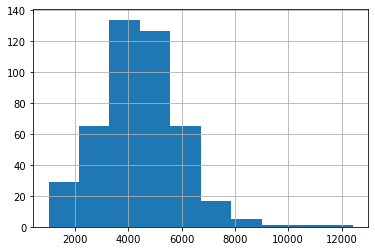

In [261]:
# REM histogram in minutes
df['rem'].hist()

In [138]:
print('Highest REM nights (and total REM hours):')
top_rem = df.iloc[df['rem'].nlargest(10).index]
top_rem['rem']/60/60

Highest REM nights (and total REM hours):


6      3.450000
18     3.108333
25     2.716667
39     2.366667
9      2.300000
21     2.283333
417    2.241667
44     2.233333
239    2.141667
19     2.133333
Name: rem, dtype: float64

In [139]:
# Clean dataframe for visualization
df_vis = df[['summary_date', 'rmssd', 'duration', 'total', 'rem']].copy()

df_vis['summary_date'] = df_vis['summary_date'].dt.strftime('%y-%m')
df_vis[['bed_hrs', 'asleep_hrs']] = df_vis[['duration', 'total']]/60/60
df_vis

,summary_date,rmssd,duration,total,rem,bed_hrs,asleep_hrs
0,18-09,61,27720,24480,6690,7.700000,6.800000
1,18-09,56,24180,22080,4530,6.716667,6.133333
2,18-09,54,27600,22440,4680,7.666667,6.233333
3,18-09,57,26220,22980,3960,7.283333,6.383333
4,18-09,48,27180,24270,3600,7.550000,6.741667
...,...,...,...,...,...,...,...
440,20-07,52,28440,24540,5700,7.900000,6.816667
441,20-07,60,28680,25950,2610,7.966667,7.208333
442,20-07,61,26880,24960,3060,7.466667,6.933333
443,20-07,61,27840,24630,5430,7.733333,6.841667


<a id='sleep_trends'></a>

## Sleep Trends Over Time
***

Text(0, 0.5, 'Sleep Hours')

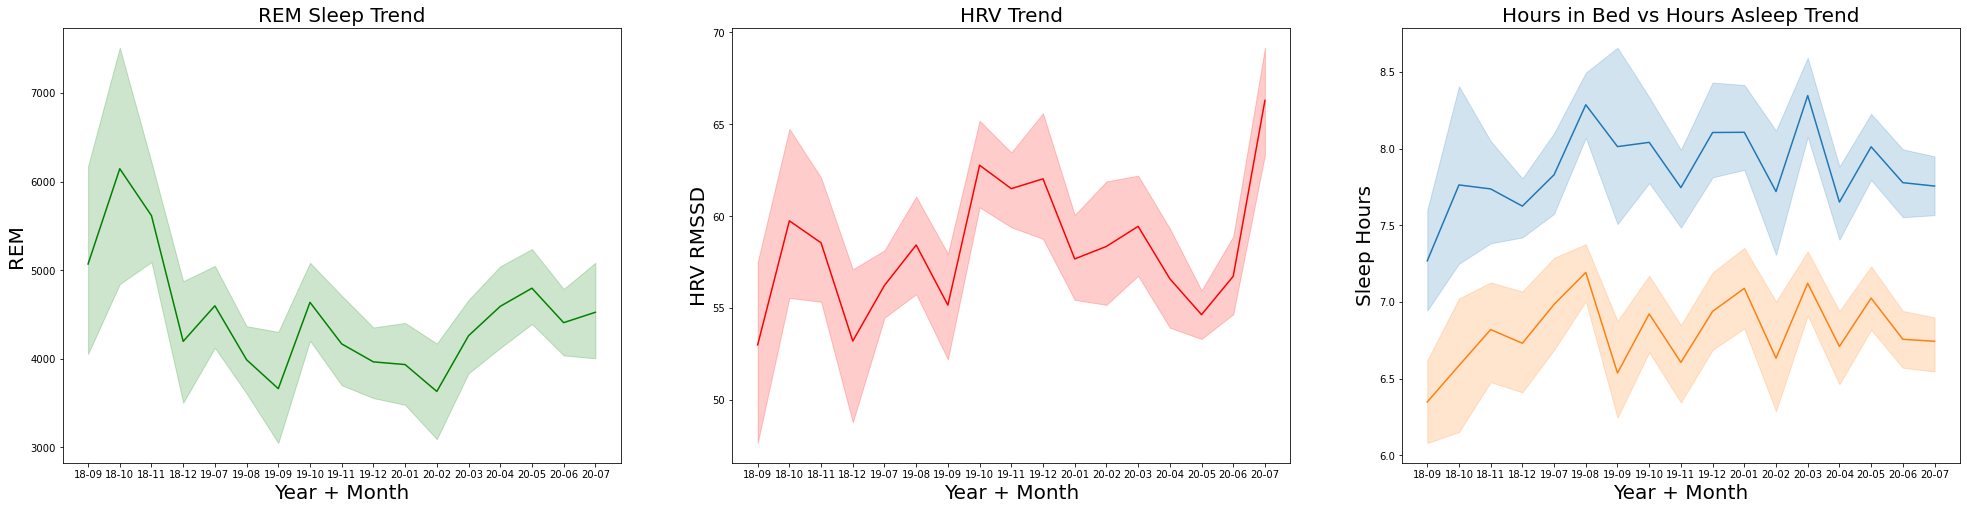

In [140]:
f, axes = plt.subplots(ncols=3, nrows=1, figsize=(34,8))

# Graph REM sleep trend
sns.lineplot(data=df_vis, x='summary_date', y='rem', color="g", ax=axes[0]).set_title("REM Sleep Trend", fontsize=20)
axes[0].set_xlabel('Year + Month', fontsize=20)
axes[0].set_ylabel('REM', fontsize=20)

# Graph HRV trend
sns.lineplot(data=df_vis, x='summary_date', y='rmssd', color="r", ax=axes[1]).set_title("HRV Trend", fontsize=20)
axes[1].set_xlabel('Year + Month', fontsize=20)
axes[1].set_ylabel('HRV RMSSD', fontsize=20)


# Graph trend of time in bed vs time actually asleep
sns.lineplot(data=df_vis, x='summary_date', y='bed_hrs', ax=axes[2]).set_title("Hours in Bed vs Hours Asleep Trend", fontsize=20)
sns.lineplot(data=df_vis, x='summary_date', y='asleep_hrs', ax=axes[2])
axes[2].set_xlabel('Year + Month', fontsize=20)
axes[2].set_ylabel('Sleep Hours', fontsize=20)

- Despite the gyms being closed for COVID, my activity went up as did my ability to recover (HRV).

<a id='correlation_matrix'></a>
## Correlation Matrix
***

,awake,bedtime_end_delta,bedtime_start_delta,breath_average,deep,duration,efficiency,hr_average,hr_lowest,is_longest,light,midpoint_at_delta,midpoint_time,onset_latency,period_id,rem,restless,rmssd,score,score_alignment,score_deep,score_disturbances,score_efficiency,score_latency,score_rem,score_total,temperature_delta,temperature_deviation,timezone,total,temperature_trend_deviation,score_resting_hr,score_recovery_index,inactive_mins,steps,cal_active,met_rate,drinks_alcohol,mouth_taping,hour_wakeup,hour_bedtime
awake,1.000000,0.067175,0.130514,0.106008,-0.247574,0.492496,-0.941600,0.118949,-0.040502,NaN,0.158189,0.274593,0.526876,0.475441,-0.027492,-0.027015,0.183820,0.113509,-0.355300,0.020407,-0.349278,-0.400358,-0.932157,-0.203851,-0.077199,-0.055519,-0.026506,-0.026506,0.123036,-0.053507,0.003257,-0.022419,-0.049395,-0.085676,0.112144,0.006811,0.004589,-0.041246,-0.051220,0.071253,0.075756
bedtime_end_delta,0.067175,1.000000,0.694859,0.084296,-0.115378,0.225214,-0.015294,0.231269,0.323794,NaN,0.253266,0.732375,0.206677,-0.023150,0.188122,0.084225,0.253620,-0.194657,-0.335020,-0.920606,-0.088902,-0.272145,-0.015821,0.000844,0.092987,0.219341,0.185590,0.185590,0.203189,0.216849,0.114341,0.048997,0.027380,0.117930,-0.016266,0.012873,0.025258,0.330652,-0.048843,0.980826,-0.559523
bedtime_start_delta,0.130514,0.694859,1.000000,0.036455,-0.188812,-0.148259,-0.128745,0.280941,0.293849,NaN,-0.020169,0.959833,-0.037918,0.141968,0.177764,-0.131904,0.161604,-0.212444,-0.587548,-0.743224,-0.183227,-0.168633,-0.120013,-0.163747,-0.113809,-0.247071,0.090856,0.090856,0.136822,-0.250840,0.057925,0.025094,0.085031,0.032351,0.040452,0.025135,0.036111,0.309896,-0.045707,0.676170,-0.533205
breath_average,0.106008,0.084296,0.036455,1.000000,-0.556737,0.044713,-0.123539,0.593940,0.344398,NaN,0.320731,0.052777,0.061967,0.059033,0.175887,0.185884,0.365759,-0.308247,-0.056264,-0.113852,-0.296604,0.068543,-0.129089,0.061632,0.182693,-0.031522,0.280587,0.280587,-0.146672,-0.014272,0.315461,0.014319,0.090652,-0.004983,-0.045884,-0.024326,-0.017589,-0.011096,-0.154129,0.081058,0.011577
deep,-0.247574,-0.115378,-0.188812,-0.556737,1.000000,0.024585,0.280713,-0.547254,-0.340869,NaN,-0.567925,-0.215449,-0.114721,-0.298772,-0.203024,-0.078642,-0.508714,0.343196,0.335084,0.179625,0.727979,0.078359,0.292307,-0.058562,-0.040094,0.195680,-0.246325,-0.246325,0.065994,0.181352,-0.235284,0.040243,-0.035875,0.025222,0.056011,0.012654,0.012566,-0.016730,0.107540,-0.108228,0.021681
duration,0.492496,0.225214,-0.148259,0.044713,0.024585,1.000000,-0.219253,0.021370,-0.021399,NaN,0.569007,0.118146,0.933241,0.264237,-0.060276,0.404620,0.222103,0.105934,0.419908,-0.004049,-0.083212,-0.226885,-0.214575,-0.106214,0.384939,0.839918,0.110453,0.110453,0.067786,0.842716,0.090193,0.042669,-0.075133,0.002835,0.057843,0.029423,0.031449,-0.073017,-0.012500,0.241507,0.154569
efficiency,-0.941600,-0.015294,-0.128745,-0.123539,0.280713,-0.219253,1.000000,-0.108091,0.047537,NaN,0.000319,-0.194215,-0.246716,-0.387864,0.010693,0.176484,-0.127198,-0.100092,0.535107,-0.020302,0.341087,0.400172,0.988751,0.150199,0.222728,0.332769,0.063194,0.063194,-0.097404,0.330890,0.019446,0.041688,0.038400,0.081344,-0.090974,0.002716,0.005286,0.025431,0.060089,-0.012900,-0.042983
hr_average,0.118949,0.231269,0.280941,0.593940,-0.547254,0.021370,-0.108091,1.000000,0.707399,NaN,0.312110,0.303617,0.110299,0.107561,0.202718,0.127670,0.414909,-0.583833,-0.183067,-0.276814,-0.413457,0.027650,-0.122917,0.089278,0.118679,-0.065304,0.411402,0.411402,-0.062578,-0.049060,0.410337,-0.051601,0.044318,-0.081145,-0.089293,-0.050082,-0.053422,0.041795,-0.241244,0.216614,-0.098750
hr_lowest,-0.040502,0.323794,0.293849,0.344398,-0.340869,-0.021399,0.047537,0.707399,1.000000,NaN,0.232823,0.296209,0.039304,0.048097,0.124778,0.064399,0.273696,-0.672426,-0.196382,-0.357013,-0.209190,-0.161378,0.028611,0.036697,0.063033,-0.002475,0.501678,0.501678,0.008480,0.000501,0.432458,-0.043095,0.106919,0.028270,-0.121139,-0.022183,-0.

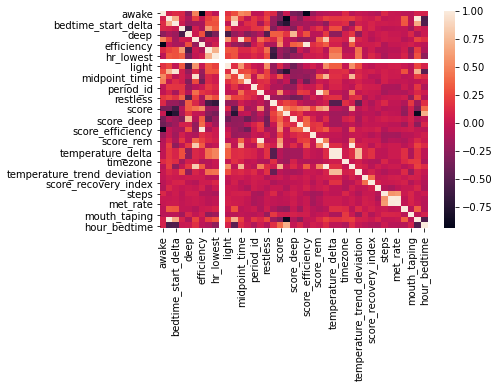

In [141]:
# Create a correlation matrix to find features most correlated with REM
corr = df.corr()
sns.heatmap(corr)
corr

Observations
- REM score is extremely correlated with most of Oura's subjective scoring metrics. Which makes sense since many weigh REM score in the calculation.
- Duration is also highly correlated with REM which I hypothesized to be true since REM occurs in the latter half of the night.
- Other interesting correlatons: Midpoint, steps, hr, alcohol, efficiency, bedtime, midpoint time, and average breaths are significant.

In [142]:
# Drop duplicate columns and those with little predictive power
df = df.drop(columns=['is_longest', 'temperature_deviation', 'temperature_trend_deviation', 'timezone', 'hr_5min', 'hypnogram_5min', 'rem','period_id', 'midpoint_at_delta', 'rmssd_5min', 'efficiency', 'bedtime_end_delta', 'bedtime_start_delta'])

# Drop Oura's calculated scores that weight REM and would lead to multicollinearity problems
df = df.drop(columns=['score_deep', 'score', 'score_total', 'total', 'score_latency', 'score_efficiency'])

In [143]:
bin_labels = ['Low', 'Medium', 'High']
df['rem_bin'] = pd.qcut(df['score_rem'], q=[0, .33, .66, .99],
                              labels=bin_labels)

Text(0.5, 0, 'Hours of Deep Sleep')

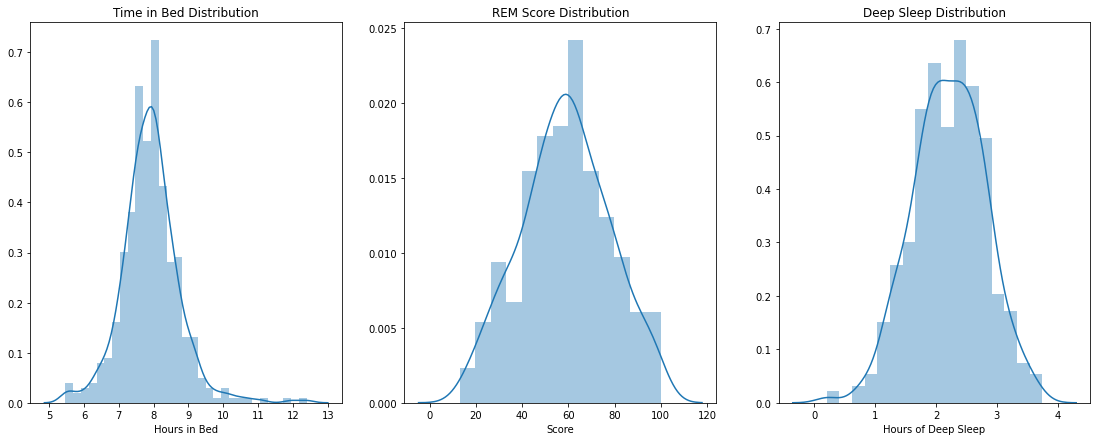

In [144]:
f, axes = plt.subplots(ncols=3, figsize=(19,7))

# Graph total time in bed in hours (instead of seconds)
sns.distplot(df['duration']/60/60, ax=axes[0]).set_title("Time in Bed Distribution")
axes[0].set_xlabel('Hours in Bed')

# Graph REM distribution
sns.distplot(df['score_rem'], ax=axes[1]).set_title("REM Score Distribution")
axes[1].set_xlabel('Score')

# Graph alseep time (in hours instead of seconds)
sns.distplot(df['deep']/60/60, ax=axes[2]).set_title("Deep Sleep Distribution")
axes[2].set_xlabel('Hours of Deep Sleep')

- There's a very strong correlation between time (in bed and asleep) and REM.


<a id='wakeup_vs_total_sleep'></a>

## Wake Up Time VS Total Sleep Time
***

Duration is very important for REM sleep, and wakeup time less so.

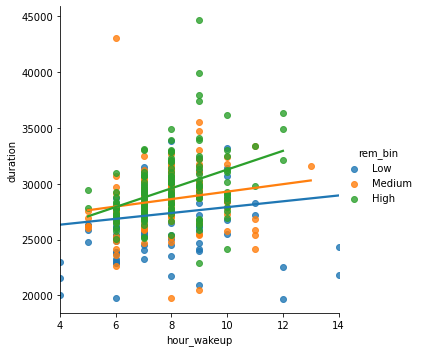

In [145]:
sns.lmplot(x='hour_wakeup', y='duration', data=df, hue='rem_bin', fit_reg=True, ci=None)

In [146]:
# Import all libraries

from sklearn.cluster import KMeans

In [149]:
# Split into predictors and target
y=df['score_rem']
X=df.iloc[::].drop(columns=['score_rem', 'bedtime_start', 'bedtime_end', 'light', 'deep', 'rem_bin','summary_date'], axis=0)

In [150]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<a id='feat_importance'></a>

## Understand Important Features
***

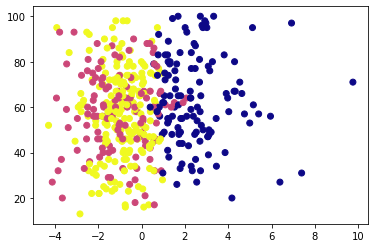

In [186]:
# I'd expect three groups of REM scores: low, mid, and high
from sklearn.decomposition import PCA

km = KMeans(n_clusters=3)
km = km.fit(X_scaled, y)
y_pred = km.predict(X_scaled)
pca = PCA().fit(X_scaled, y)
pca_c = pca.transform(X_scaled)

# Visualize groupings
plt.scatter(pca_c[:, 0], y, c=y_pred, cmap='plasma')

### PCA Feature Importance
***

In [177]:
for variance, feat in zip(pca.explained_variance_ratio_, X.columns):
    print(f'{feat}: {round(variance,2)} variance explained')

awake: 0.18 variance explained
breath_average: 0.13 variance explained
duration: 0.11 variance explained
hr_average: 0.1 variance explained
hr_lowest: 0.07 variance explained
midpoint_time: 0.05 variance explained
onset_latency: 0.05 variance explained
restless: 0.05 variance explained
rmssd: 0.04 variance explained
score_alignment: 0.04 variance explained
score_disturbances: 0.04 variance explained
temperature_delta: 0.03 variance explained
score_resting_hr: 0.03 variance explained
score_recovery_index: 0.02 variance explained
inactive_mins: 0.02 variance explained
steps: 0.01 variance explained
cal_active: 0.01 variance explained
met_rate: 0.01 variance explained
drinks_alcohol: 0.01 variance explained
mouth_taping: 0.0 variance explained
hour_wakeup: 0.0 variance explained
hour_bedtime: 0.0 variance explained


### Ensemble Trees Feature Importance

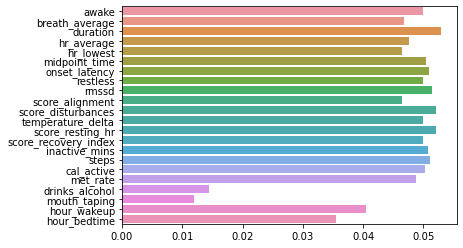

In [241]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier()
et.fit(X_scaled, y)

sns.barplot(x=et.feature_importances_, y=X.columns, orient="h")

<a id='conclusion'></a>
# Conclusion
***

<a id='rem_plan'></a>
## REM Tips

I've learned several tips to increase REM score and total time. These include:
- Sleep longer.

- Maintain a consistent sleep & wake schedule.

- Wake up later.

- Avoid lifestyle habits that delay recovery (increased resting heart rate & increased respiratory rate)